In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 10.9 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


### 1. 데이터 전처리
  - 문장의 토큰화, 태깅 등의 전처리 수행
  - 영어, 독어 전처리 모듈 설치

In [2]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [3]:
import spacy

spacy_en = spacy.load('en') # 영어 토큰화
spacy_de = spacy.load('de') # 독어 토큰화

In [4]:
# 토큰화 테스트
tokenized = spacy_en.tokenizer('I am a student.')

for idx, token in enumerate(tokenized):
  print(f'index {idx}: {token.text}')

index 0: I
index 1: am
index 2: a
index 3: student
index 4: .


In [5]:
# 영어, 독어 토큰화 함수 정의

# 독어 문장 토큰화 함수 (순서 뒤집지 않음)
def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)]

# 영어 문장 토큰화 함수
def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

In [6]:
# 데이터셋에 대한 구체적인 전처리 내용 명시
# batch_first 속성 값 True (Seq2Seq 모델과는 다름)
from torchtext.data import Field, BucketIterator

# 소스: 독어
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

# 타겟: 영어
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

In [7]:
# load Multi30k
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 761kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 246kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 237kB/s]


In [8]:
print(f'train: {len(train_dataset.examples)}')
print(f'validation: {len(valid_dataset.examples)}')
print(f'test: {len(test_dataset.examples)}')

train: 29000
validation: 1014
test: 1000


In [9]:
# 영어, 독어 단어 사전 생성
# 독일어를 영어로 번역할 때, 초기 input demension을 알기 위함

SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f'len(SRC): {len(SRC.vocab)}')
print(f'len(TRG): {len(TRG.vocab)}')

len(SRC): 7855
len(TRG): 5893


In [10]:
# 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 함
# 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 하는 것이 좋음
# 배치 크기: 128

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
for i, batch in enumerate(train_iterator):
  src = batch.src
  trg = batch.trg

  print(f'first batch size: {src.shape}')

  # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
  for i in range(src.shape[1]):
    print(f'index {i}: {src[0][i].item()}')

  break

### 2. Multi Head Attention 아키텍처
  - 쿼리(Q)
  - 키(K)
  - 값(V)
  - 하이퍼 파라미터
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - n_heads: 헤드의 개수 = scaled dot-product attention의 개수
    - dropout_ratio: 드롭아웃 비율

In [12]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device) -> None:
      super().__init__()

      assert hidden_dim % n_heads == 0

      # 임베딩 차원
      self.hidden_dim = hidden_dim
      # 헤드의 개수: 서로 다른 어텐션 컨셉의 수
      self.n_heads = n_heads
      # 각 헤드에서의 임베딩 차원
      self.head_dim = hidden_dim // n_heads

      # query 값에 적용될 FC 레이어
      self.fc_q = nn.Linear(hidden_dim, hidden_dim)
      # key 값에 적용될 FC 레이어
      self.fc_k = nn.Linear(hidden_dim, hidden_dim)
      # value 값에 적용될 FC 레이어
      self.fc_v = nn.Linear(hidden_dim, hidden_dim)

      self.fc_o = nn.Linear(hidden_dim, hidden_dim)

      self.dropout = nn.Dropout(dropout_ratio)

      self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask=None):
    batch_size = query.shape[0]

    # query: [batch_size, query_len, hidden_dim]
    # key: [batch_size, key_len, hidden_dim]
    # value: [batch_size, value_len, hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # Q: [batch_size, query_len, hidden_dim]
    # K: [batch_size, key_len, hidden_dim]
    # V: [batch_size, value_len, hidden_dim]

    # hidden_dim → n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # attention energy 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    # 마스크 사용하는 경우,
    if mask is not None:
      # 마스크 값이 0인 부분을 -1e10으로 채우기
      energy = energy.masked_fill(mask==0, -1e10)

    # 어텐션 스코어 계산: 각 단어에 대한 확률 값
    attention = torch.softmax(energy, dim=-1)

    # attention: [batch_size, n_heads, query_len, key_len]

    # scaled dot-product attention 계산
    x = torch.matmul(self.dropout(attention), V)

    # x: [batch_size, n_heads, query_len, head_dim]
    x = x.permute(0, 2, 1, 3).contiguous()

    # x: [batch_size, query_len, n_heads, head_dim]
    x = x.view(batch_size, -1, self.hidden_dim)

    # x: [batch_size, query_len, hidden_dim]
    x = self.fc_o(x)

    return x, attention

### 3. Position-wise Feedforward 아키텍처
  - 입력, 출력 차원 동일
  - 하이퍼 파라미터
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - pf_dim: feedforward 레이어에서의 내부 임베딩 차원
    - dropout_ratio: 드롭아웃 비율

In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
      super().__init__()

      self.fc_1 = nn.Linear(hidden_dim, pf_dim)
      self.fc_2 = nn.Linear(pf_dim, hidden_dim)

      self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, x):

      # x: [batch_size, seq_len, hidden_dim]

      x = self.dropout(torch.relu(self.fc_1(x)))

      # x: [batch_size, seq_len, pf_dim]

      x = self.fc_2(x)

      # x: [batch_size, seq_len, hidden_dim]

      return x

### 4. 인코더 레이어 아키텍처
  - 하나의 인코더 레이어에 대해 정의
  - 입출력 차원 동일
  - 위의 특징으로 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩하여 사용
  - 하이퍼 파라미터
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - n_heads: 헤드의 개수 = scaled dot-product attention의 개수
    - pf_dim: feedforward 레이어에서의 내부 임베딩 차원
    - dropout_ratio: 드롭아웃 비율
  - 패드 토큰에 대하여 마스크 값 0으로 설정

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

### 5. 인코더(Encoder) 아키텍처
  - 전체 인코더 아키텍처를 정의합니다.
  - 하이퍼 파라미터(hyperparameter)
    - input_dim: 하나의 단어에 대한 원 핫 인코딩 차원
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - n_layers: 내부적으로 사용할 인코더 레이어의 개수
    - n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    - pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    - dropout_ratio: 드롭아웃(dropout) 비율
    - max_length: 문장 내 최대 단어 개수
  - 원본 논문과는 다르게 위치 임베딩(positional embedding)을 학습하는 형태로 구현합니다.
    - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
  - 패드 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

### 6. 디코더 레이어 아키텍처
  - 하나의 디코더 레이어에 대해 정의
  - 입출력 차원 동일
  - 트랜스포머의 디코더도 디코더 레이어를 여러 번 중첩해 사용
  - 디코더 레이어에서는 두 개의 멀티 헤드 어텐션 레이어가 사용됨
  - 하이퍼 파라미터
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - n_heads: 헤드의 개수 = scaled dot-product attention의 개수
    - pf_dim: feedforward 레이어에서의 내부 임베딩 차원
    - dropout_ratio: 드롭아웃 비율
  - 소스 문장의 패드 토큰에 대하여 마스크 값을 0으로 설정
  - 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크 사용

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

### 7. 디코더(Decoder) 아키텍처
  - 전체 디코더 아키텍처를 정의
  - 하이퍼 파라미터(hyperparameter)
    - output_dim: 하나의 단어에 대한 원 핫 인코딩 차원
    - hidden_dim: 하나의 단어에 대한 임베딩 차원
    - n_layers: 내부적으로 사용할 인코더 레이어의 개수
    - n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    - pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    - dropout_ratio: 드롭아웃(dropout) 비율
    - max_length: 문장 내 최대 단어 개수
  - 원본 논문과는 다르게 위치 임베딩(positional embedding)을 학습하는 형태로 구현
    - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식
  - Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣어야 함.
    - 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습 가능
  - 소스 문장의 패드 토큰에 대하여 마스크(mask) 값을 0으로 설정
  - 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크 사용

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

### 8. 트랜스포머 아키텍처
  - 전체 트랜스포머 모델 정의
  - 입력이 들어왔을 때, 앞서 정의된 인코더와 디코더를 거쳐 출력 문장 생성

In [19]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

### 9. 학습

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [21]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [22]:
# 모델 가중치 파라미터 초기화
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [23]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

In [24]:
# 학습 및 평가 함수 정의
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [25]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [26]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
# 학습 및 검증 진행
# epoch=10
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')


Epoch: 01 | Time: 0m 17s
	Train Loss: 4.241 | Train PPL: 69.457
	Validation Loss: 3.042 | Validation PPL: 20.945
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.831 | Train PPL: 16.967
	Validation Loss: 2.319 | Validation PPL: 10.163
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.246 | Train PPL: 9.446
	Validation Loss: 1.996 | Validation PPL: 7.363
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.893 | Train PPL: 6.636
	Validation Loss: 1.814 | Validation PPL: 6.135
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.642 | Train PPL: 5.167
	Validation Loss: 1.715 | Validation PPL: 5.559
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.456 | Train PPL: 4.287
	Validation Loss: 1.653 | Validation PPL: 5.221
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.304 | Train PPL: 3.682
	Validation Loss: 1.630 | Validation PPL: 5.104
Epoch: 08 | Time: 0m 16s
	Train Loss: 1.176 | Train PPL: 3.242
	Validation Loss: 1.616 | Validation PPL: 5.034
Epoch: 09 | Time: 0m 17s
	Train Loss: 1.064 | Train PPL: 2.899
	Validation Loss: 1.621 | Validation PPL: 5.0

In [29]:
# 학습된 모델 저장
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 10. 모델 최종 테스트 결과 확인

In [30]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrb

--2022-03-26 05:55:59--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrb
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108550 (106K) [text/html]
Saving to: ‘EbWFiKBmscFBrb’

EbWFiKBmscFBrb      100%[===================>] 106.01K   308KB/s    in 0.3s    

2022-03-26 05:56:01 (308 KB/s) - ‘EbWFiKBmscFBrb’ saved [108550/108550]



In [31]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.671 | Test PPL: 5.318


In [32]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [33]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her son enjoying a beautiful day . <eos>


### 11. 어텐션 맵 시각화

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [35]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her son enjoying a beautiful day . <eos>


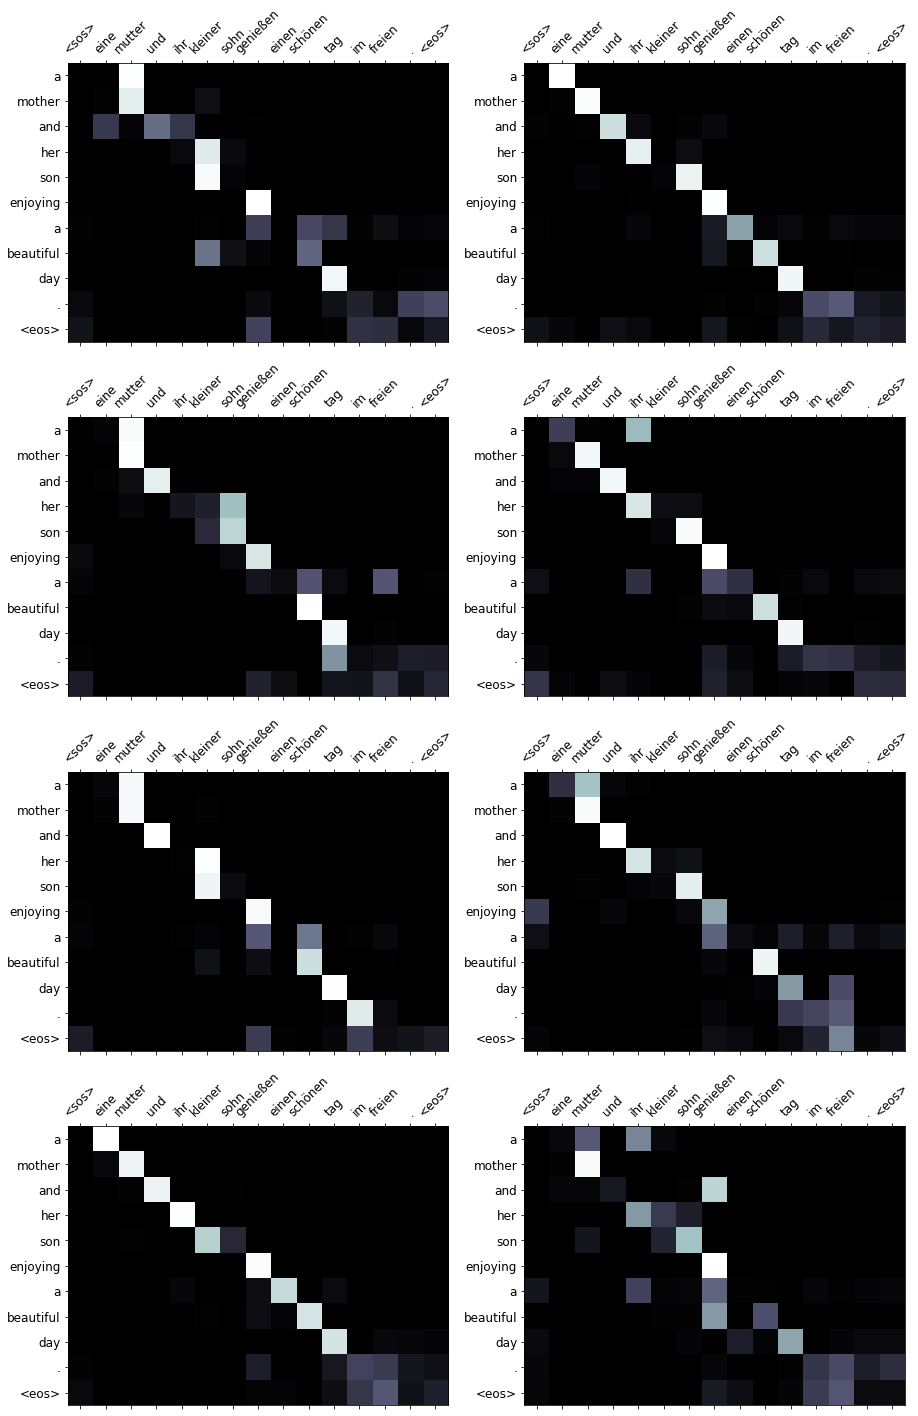

In [36]:
display_attention(src, translation, attention)

### 12. BLEU Score 계산

In [37]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [38]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'are', 'sitting', 'in', 'blue', 'chairs', 'on', 'blue', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
예측: ['all', 'people', 'in', 'the', 'group', 'of', 'umbrellas', 'stand', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
예측: ['a', 'man', 'in', 'a', 'yellow', 'jersey', 'is', 'discussing', 'something', 'to', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
예측: ['two', 'young', 'children', 'are', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
예측: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[600/1000]
예측: ['a', 'group', 'of', 'men', 'are', 'sitt